# This notebook creates a very simple U-Net to segment clouds
Important remarks:
- The test-set is not being used
- The train set will be splitted into train and validation sets.
- The dataset creation is discussed in: https://medium.com/@cordmaur/how-to-create-a-custom-dataset-loader-in-pytorch-from-scratch-for-multi-band-satellite-images-c5924e908edf
- More information full explanation can can be found on the medium article: https://medium.com/@cordmaur/creating-a-very-simple-u-net-model-with-pytorch-for-semantic-segmentation-of-satellite-images-223aa216e705
- The training phase with 50 epochs takes around 3:30hs. 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import gc
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
from pathlib import Path
from torch.utils.data import Dataset, DataLoader, sampler
from PIL import Image
import torch
import matplotlib.pyplot as plt
import time


# !pip install tensorflow==2.0

In [3]:
# !pip install keras-unet
# import tensorflow as tf

In [4]:
# from keras.layers import Input

## Creating the dataset

In [5]:
class CloudDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, gt_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir, gt_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir, gt_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),
                 'gt': gt_dir/r_file.name.replace('red', 'gt')}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
        y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x, y
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [6]:
base_path = Path('../input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_training')
data = CloudDataset(base_path/'train_red', 
                    base_path/'train_green', 
                    base_path/'train_blue', 
                    base_path/'train_nir',
                    base_path/'train_gt')
len(data)

8400

In [7]:
x, y = data[1000]
x.shape, y.shape

(torch.Size([4, 384, 384]), torch.Size([384, 384]))

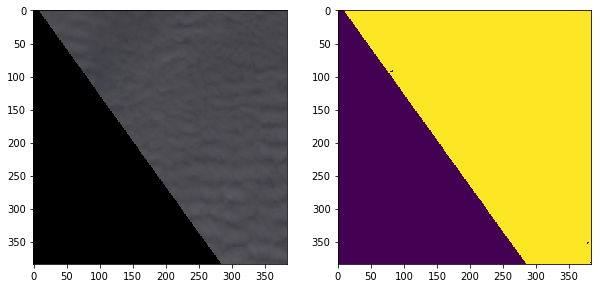

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,9))
ax[0].imshow(data.open_as_array(150))
ax[1].imshow(data.open_mask(150))

In [9]:
train_ds, valid_ds = torch.utils.data.random_split(data, (6000, 2400))

In [10]:
train_ds

In [11]:
train_dl = DataLoader(train_ds, batch_size=12)
valid_dl = DataLoader(valid_ds, batch_size=12)

In [12]:
xb, yb = next(iter(train_dl))
xb.shape, yb.shape

(torch.Size([12, 4, 384, 384]), torch.Size([12, 384, 384]))

# The model

In [13]:
from torch import nn

def doubleConv(in_channels, out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = True),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_channels, out_channels, kernel_size = 3, padding = True),
        nn.ReLU(inplace = True)
        )
    return conv

class UNET(nn.Module):
    def __init__(self):
        super(UNET, self).__init__()

        self.max_pool= nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.down_conv1 = doubleConv(4, 64)
        self.down_conv2 = doubleConv(64, 128)
        self.down_conv3 = doubleConv(128, 256)
        self.down_conv4 = doubleConv(256, 512)
        self.down_conv5 = doubleConv(512, 1024)

        self.up_pool1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size = 2, stride = 2)
        self.up_pool2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        self.up_pool3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        self.up_pool4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        
        self.upconv1 = doubleConv(1024, 512)
        self.upconv2 = doubleConv(512, 256)
        self.upconv3 = doubleConv(256, 128)
        self.upconv4 = doubleConv(128, 64)
        self.out = nn.Conv2d(in_channels = 64, out_channels = 2, kernel_size = 3, padding = True)
        
    def __call__(self, image):
        x1 = self.down_conv1(image)
        x2 = self.max_pool(x1)
        x3 = self.down_conv2(x2)
        x4 = self.max_pool(x3)
        x5 = self.down_conv3(x4)
        x6 = self.max_pool(x5)
        x7 = self.down_conv4(x6)
        x8 = self.max_pool(x7)
        x9 = self.down_conv5(x8)
        
        x10 = self.up_pool1(x9)
        x11 = self.upconv1(torch.cat([x10, x7], 1))
        x12 = self.up_pool2(x11)
        x13 = self.upconv2(torch.cat([x12, x5], 1))
        x14 = self.up_pool3(x13)
        x15 = self.upconv3(torch.cat([x14, x3], 1))
        x16 = self.up_pool4(x15)
        x17 = self.upconv4(torch.cat([x16, x1], 1))
        x = self.out(x17)
        
#         x_arr = [x1, x2, x3, x4, x5, x6, x7, x8, x9, x10, x11, x12, x13, x14, x15, x16, x17]
#         for i in x_arr:
#             print(i.shape)
#         print(x.shape)

        return x

In [14]:
unet = UNET()

# from keras_unet.models import vanilla_unet

# unet = vanilla_unet(input_shape=(384, 384, 4))

In [15]:
# from tensorflow import keras
# keras.utils.plot_model(unet, show_shapes=True)

In [16]:
# testing one pass
xb, yb = next(iter(train_dl))

xb.shape, yb.shape

(torch.Size([12, 4, 384, 384]), torch.Size([12, 384, 384]))

In [17]:
# np_tensor = xb.numpy()
# xb = tf.convert_to_tensor(np_tensor)

pred = unet(xb)

In [18]:
import time
from IPython.display import clear_output

def train(model, train_dl, valid_dl, loss_fn, optimizer, acc_fn, epochs=300):
    start = time.time()
    model.cuda()

    train_loss, valid_loss = [], []

    best_acc = 0.0

    for epoch in range(epochs):
        print('Epoch {}/{}'.format(epoch, epochs - 1))
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train(True)  # Set trainind mode = true
                dataloader = train_dl
            else:
                model.train(False)  # Set model to evaluate mode
                dataloader = valid_dl

            running_loss = 0.0
            running_acc = 0.0

            step = 0

            # iterate over data
            for x, y in dataloader:
                x = x.cuda()
                y = y.cuda()
                step += 1

                # forward pass
                if phase == 'train':
                    # zero the gradients
                    optimizer.zero_grad()
                    outputs = model(x)
                    loss = loss_fn(outputs, y)

                    # the backward pass frees the graph memory, so there is no 
                    # need for torch.no_grad in this training pass
                    loss.backward()
                    optimizer.step()
                    # scheduler.step()

                else:
                    with torch.no_grad():
                        outputs = model(x)
                        loss = loss_fn(outputs, y.long())

                # stats - whatever is the phase
                acc = acc_fn(outputs, y)

                running_acc  += acc*dataloader.batch_size
                running_loss += loss*dataloader.batch_size 

                if step % 100 == 0:
                    # clear_output(wait=True)
                    print('Current step: {}  Loss: {}  Acc: {}  AllocMem (Mb): {}'.format(step, loss, acc, torch.cuda.memory_allocated()/1024/1024))
                    # print(torch.cuda.memory_summary())
                
                
            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_acc / len(dataloader.dataset)

            clear_output(wait=True)
            print('Epoch {}/{}'.format(epoch, epochs - 1))
            print('-' * 10)
            print('{} Loss: {:.4f} Acc: {}'.format(phase, epoch_loss, epoch_acc))
            print('-' * 10)

            train_loss.append(epoch_loss) if phase=='train' else valid_loss.append(epoch_loss)

    time_elapsed = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))    
    
    return train_loss, valid_loss    

def acc_metric(predb, yb):
    return (predb.argmax(dim=1) == yb.cuda()).float().mean()

In [19]:
loss_fn = nn.CrossEntropyLoss()
# opt = torch.optim.Adam(unet.parameters(), lr=0.0001)
opt = torch.optim.SGD(unet.parameters(), lr=0.0001, momentum=0.9)

# Utpo 10^-8
# unet.compile(optimizer=Adam(), loss="binary_crossentropy", metrics=["accuracy"])

train_loss, valid_loss = train(unet, train_dl, valid_dl, loss_fn, opt, acc_metric, epochs=1)

Epoch 0/0
----------
valid Loss: 0.6626 Acc: 0.6866111755371094
----------
Training complete in 7m 58s


In [20]:
# Specify a path to save to
PATH = "./model.pt"
# Save
torch.save(unet.state_dict(), PATH)

In [21]:
# callbacks = [
#     EarlyStopping(patience=10, verbose=1),
#     ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
#     ModelCheckpoint('model-tgs-salt.h5', verbose=1, save_best_only=True, save_weights_only=True)
# ]

# results = model.fit(X_train, y_train, batch_size=32, epochs=50, callbacks=callbacks,\
#                     validation_data=(X_valid, y_valid))

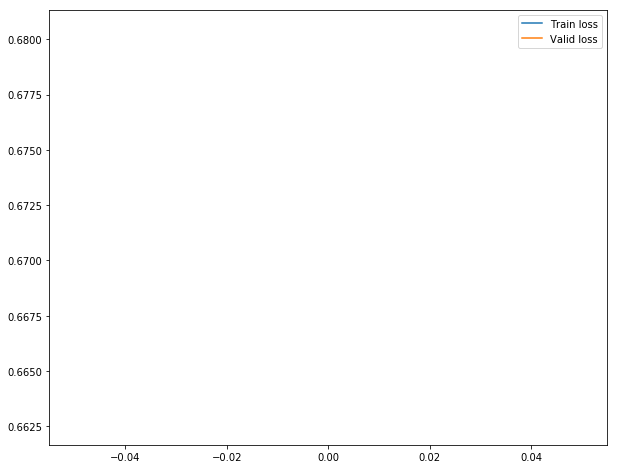

In [22]:
plt.figure(figsize=(10,8))
plt.plot(train_loss, label='Train loss')
plt.plot(valid_loss, label='Valid loss')
plt.legend()

In [23]:
def batch_to_img(xb, idx):
    img = np.array(xb[idx,0:3])
    return img.transpose((1,2,0))

def predb_to_mask(predb, idx):
    p = torch.functional.F.softmax(predb[idx], 0)
    return p.argmax(0).cpu()

In [24]:
xb, yb = next(iter(train_dl))

with torch.no_grad():
    predb = unet(xb.cuda())
    
predb.shape

torch.Size([12, 2, 384, 384])

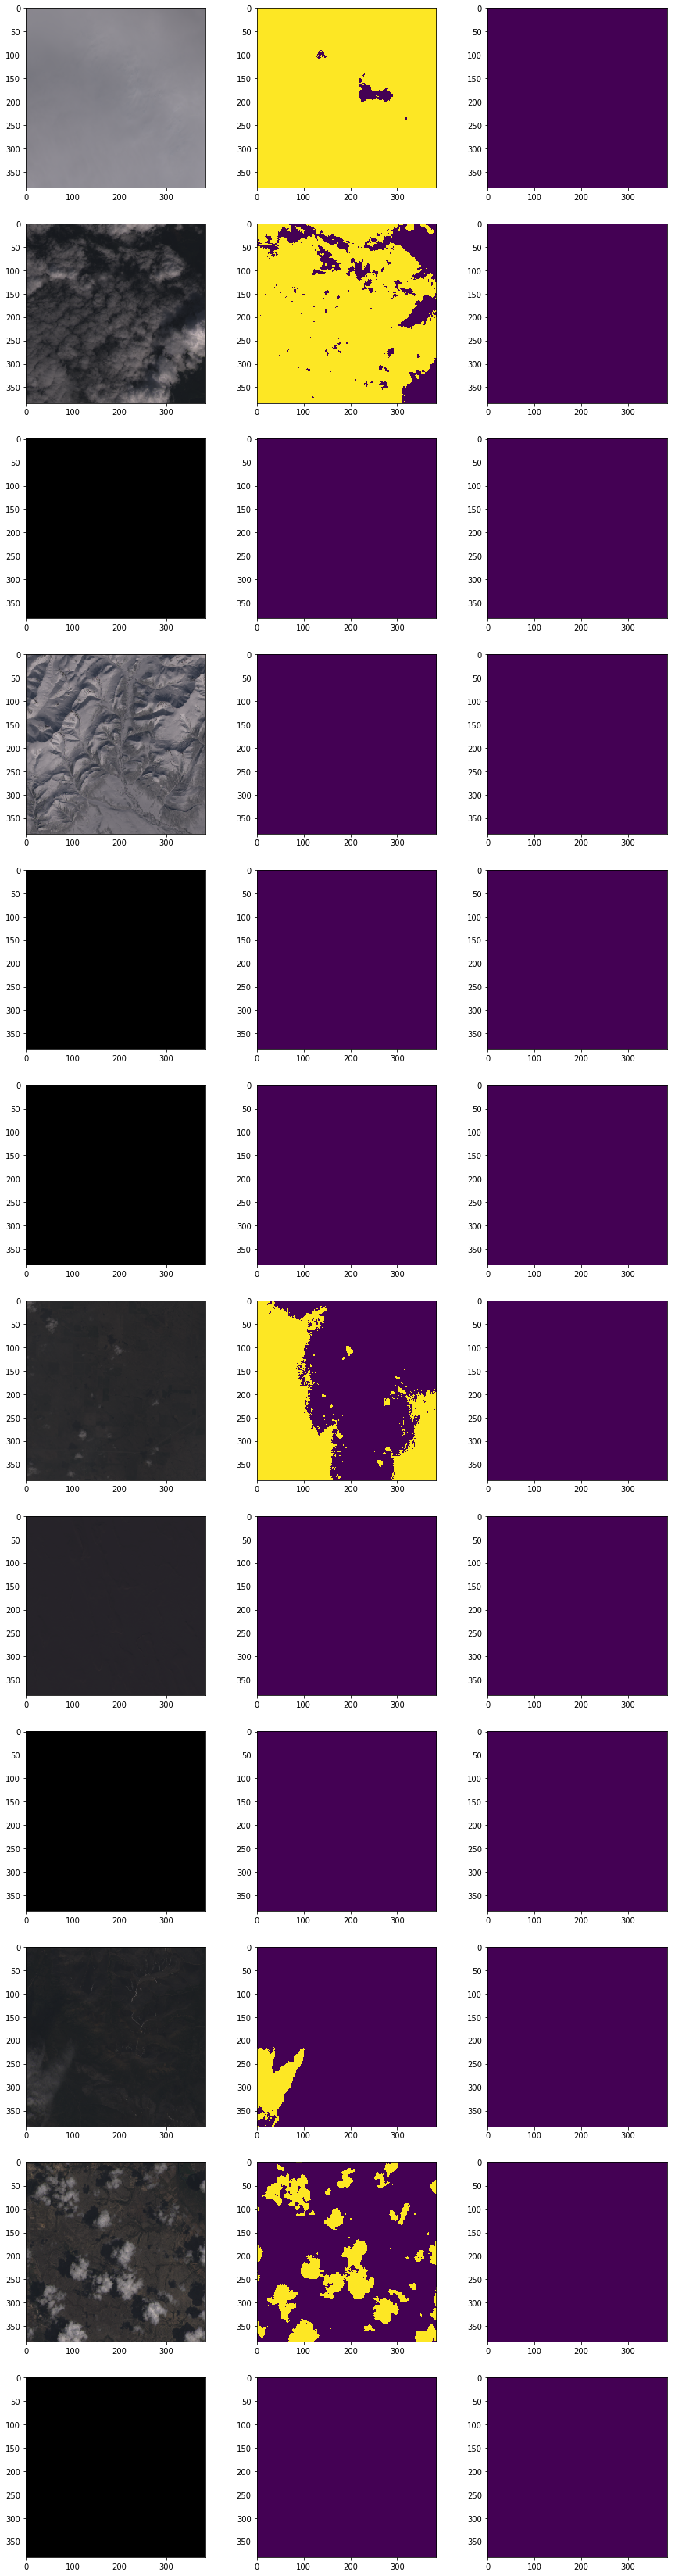

In [25]:
bs = 12
fig, ax = plt.subplots(bs,3, figsize=(15,bs*5))
for i in range(bs):
    ax[i,0].imshow(batch_to_img(xb,i))
    ax[i,1].imshow(yb[i])
    ax[i,2].imshow(predb_to_mask(predb, i))

In [26]:
class CloudTestDataset(Dataset):
    def __init__(self, r_dir, g_dir, b_dir, nir_dir, pytorch=True):
        super().__init__()
        
        # Loop through the files in red folder and combine, into a dictionary, the other bands
        self.files = [self.combine_files(f, g_dir, b_dir, nir_dir) for f in r_dir.iterdir() if not f.is_dir()]
        self.pytorch = pytorch
        
    def combine_files(self, r_file: Path, g_dir, b_dir,nir_dir):
        
        files = {'red': r_file, 
                 'green':g_dir/r_file.name.replace('red', 'green'),
                 'blue': b_dir/r_file.name.replace('red', 'blue'), 
                 'nir': nir_dir/r_file.name.replace('red', 'nir'),}

        return files
                                       
    def __len__(self):
        
        return len(self.files)
     
    def open_as_array(self, idx, invert=False, include_nir=False):

        raw_rgb = np.stack([np.array(Image.open(self.files[idx]['red'])),
                            np.array(Image.open(self.files[idx]['green'])),
                            np.array(Image.open(self.files[idx]['blue'])),
                           ], axis=2)
    
        if include_nir:
            nir = np.expand_dims(np.array(Image.open(self.files[idx]['nir'])), 2)
            raw_rgb = np.concatenate([raw_rgb, nir], axis=2)
    
        if invert:
            raw_rgb = raw_rgb.transpose((2,0,1))
    
        # normalize
        return (raw_rgb / np.iinfo(raw_rgb.dtype).max)
    

    def open_mask(self, idx, add_dims=False):
        
        raw_mask = np.array(Image.open(self.files[idx]['gt']))
        raw_mask = np.where(raw_mask==255, 1, 0)
        
        return np.expand_dims(raw_mask, 0) if add_dims else raw_mask
    
    def __getitem__(self, idx):
        
        x = torch.tensor(self.open_as_array(idx, invert=self.pytorch, include_nir=True), dtype=torch.float32)
#         y = torch.tensor(self.open_mask(idx, add_dims=False), dtype=torch.torch.int64)
        
        return x
    
    def open_as_pil(self, idx):
        
        arr = 256*self.open_as_array(idx)
        
        return Image.fromarray(arr.astype(np.uint8), 'RGB')
    
    def __repr__(self):
        s = 'Dataset class with {} files'.format(self.__len__())

        return s

In [27]:
base_path = Path('../input/38cloud-cloud-segmentation-in-satellite-images/38-Cloud_test')
data = CloudTestDataset(base_path/'test_red', 
                    base_path/'test_green', 
                    base_path/'test_blue', 
                    base_path/'test_nir')

In [28]:
test_ds = data

In [29]:
test_dl = DataLoader(test_ds, batch_size=12)

In [30]:
# for xb in test_dl:
#     xb = xb.cuda()
#     with torch.no_grad():
#         predb = unet(xb.cuda())
#     bs = 12
#     for i in range(bs):
# #         plt.figure(figsize=(384,384))
#         ax.imsave(predb_to_mask(predb, "gt_"+str(yb)))